In [1]:
#import every function and library needed

import cv2
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.io import imread
from skimage.transform import rotate, resize

In [2]:
#This function alignes two images based on ORB detected simularities. 
#Code from https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/ and slightly modified

MAX_FEATURES = 1000
GOOD_MATCH_PERCENT = 0.15

def alignImages(film, grayFilm, grayFilter):

    filmGray = grayFilm
    colorFilterGray = grayFilter

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(filmGray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(colorFilterGray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(filmGray, keypoints1, colorFilterGray, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = colorFilterGray.shape
    filmReg = cv2.warpPerspective(film, h, (width, height))
    return filmReg, colorFilterGray, h

(4292, 1908, 3)
uint8
(4054, 2921)


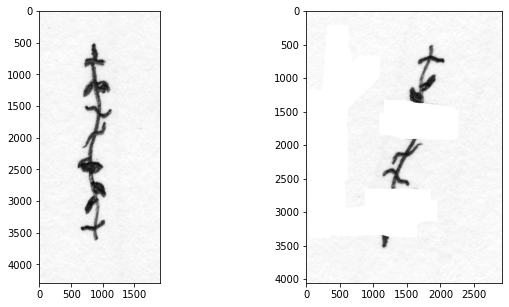

In [12]:
# Open the image files.
colorFilter = imread('Vine-1/vine_clear.tif')
colorFilter = cv2.convertScaleAbs(colorFilter, alpha=(255.0/65535.0))
film = imread('Vine-1/vine_scratches_censored.tif')
film = cv2.convertScaleAbs(film, alpha=(255.0/65535.0))

#convert film colorFilter to B&W, needed for processing. 
film = cv2.cvtColor(film, cv2.COLOR_BGR2GRAY)
grayFilter = cv2.cvtColor(colorFilter, cv2.COLOR_BGR2GRAY)


# Turn into nice data that the ORB will be pleased by
print(colorFilter.shape)
print(film.dtype)
print(film.shape)

#Process the black and white film to get a crisper image
grayFilm = film
grayFilter = grayFilter


#prepare to send images to alignment function and last checks
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].imshow(grayFilter, cmap='gray')
axs[1].imshow(grayFilm, cmap='gray')

In [13]:
#Align photos, using the borrowed ORB matching
print("Aligning images ...")
#Check to make sure we are passing good images of the right type
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, imFilt, h = alignImages(film, grayFilm, grayFilter)
# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...
Estimated homography : 
 [[-9.85642832e-01 -2.45487889e-01  2.88199602e+03]
 [ 2.65862504e-01 -9.69190894e-01  3.64491008e+03]
 [ 4.23551156e-06  3.16071182e-06  1.00000000e+00]]


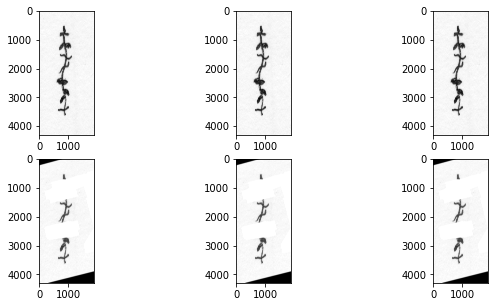

In [14]:
#Break the colorFilter into component RGB colors

colorFilterR = colorFilter[:,:,0]
colorFilterG = colorFilter[:,:,1]
colorFilterB = colorFilter[:,:,2]

film = imReg

fig, axs = plt.subplots(2,3, figsize=(10, 5))
axs[0,0].imshow(colorFilterR, cmap='gray')
axs[0,1].imshow(colorFilterG, cmap='gray')
axs[0,2].imshow(colorFilterB, cmap='gray')
axs[1,0].imshow(film, cmap='gray')
axs[1,1].imshow(film, cmap='gray')
axs[1,2].imshow(film, cmap='gray')
plt.show()

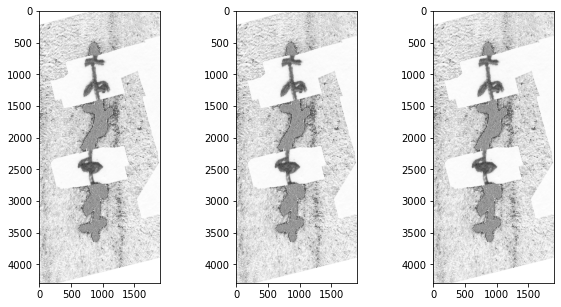

In [20]:
#Multiply each colorFilter color by the black and white film photo

fig, axs = plt.subplots(1,3, figsize=(10, 5))
R = colorFilterR * film
G = colorFilterG * film
B = colorFilterB * film
axs[0].imshow(R, cmap='Greys')
axs[1].imshow(G, cmap='Greys')
axs[2].imshow(B, cmap='Greys')
plt.show()

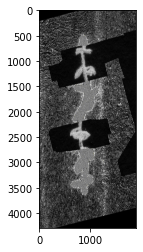

In [16]:
#Add the color spectra together to get reconstructed color image

R_new = np.expand_dims(R, 2)
G_new = np.expand_dims(G, 2)
B_new = np.expand_dims(B, 2)
temp = np.append(R_new, G_new, axis=2)
reconst_img = np.append(temp, B_new, axis=2)

plt.imshow(reconst_img/255)

In [17]:
#Last checks as the programer/artist pleases

plt.imshow(imColor_Green, cmap="gray")
plt.colorbar()
print(imColor_Green)

# Write colorized image to disk.
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename);
cv2.imwrite(outFilename, imColor_Green)

NameError: name 'imColor_Green' is not defined

In [10]:
!pip install imagecodecs

     |████████████████████████████████| 33.2 MB 9.3 MB/s eta 0:00:01     |██████████████████████████████▌ | 31.6 MB 9.3 MB/s eta 0:00:01
